Смотрим на получившийся датасет

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

Признаки:
- *_last - значение соответствующей характеристики в последний день периода (для многих это max значение за период)
- *_max - max значение соответствующей характеристики за период (30-дневный)
- *_diff - разность значений характеристики в послежний и первый день периода
- block - номер периода относительно начала работы диска (скоррелирован с date)

In [2]:
data = pd.read_csv("disk_data_blocks_30_days.csv")

In [3]:
data

,date,serial_number,smart_5_last,smart_9_last,smart_187_last,smart_188_last,smart_192_last,smart_198_last,smart_199_last,smart_240_last,smart_241_last,smart_242_last,block,smart_5_diff,smart_187_diff,smart_198_diff,smart_199_max,target
0,2022-12-01,ZL201VZX,0.0,17955.0,0.0,0.0,3.0,0.0,0.0,17390.0,1.014789e+11,2.531417e+11,25,0.0,0.0,0.0,0.0,0
1,2022-11-01,ZL201VZX,0.0,17220.0,0.0,0.0,3.0,0.0,0.0,16658.0,9.977201e+10,2.446438e+11,24,0.0,0.0,0.0,0.0,0
2,2022-10-02,ZL201VZX,0.0,16507.0,0.0,0.0,3.0,0.0,0.0,15948.0,9.812132e+10,2.348104e+11,23,0.0,0.0,0.0,0.0,0
3,2022-09-02,ZL201VZX,0.0,15778.0,0.0,0.0,3.0,0.0,0.0,15222.0,9.597480e+10,2.249148e+11,22,0.0,0.0,0.0,0.0,0
4,2022-08-03,ZL201VZX,0.0,15064.0,0.0,0.0,3.0,0.0,0.0,14512.0,9.316893e+10,2.145396e+11,21,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240616,2021-11-06,ZTM096M0,0.0,3762.0,0.0,0.0,0.0,0.0,0.0,3123.0,4.311050e+10,4.500844e+10,5,0.0,0.0,0.0,0.0,0
240617,2021-10-07,ZTM096M0,0.0,3044.0,0.0,0.0,0.0,0.0,0.0,2407.0,3.717902e+10,3.707048e+10,4,0.0,0.0,0.0,0.0,0
240618,2021-09-07,ZTM096M0,0.0,2334.0,0.0,0.0,0.0,0.0,0.0,1701.0,2.878232e+10,2.723231e+10,3,0.0,0.0,0.0,0.0,0
240619,2021-08-08,ZTM096M0,0.0,1604.0,0.0,0.0,0.0,0.0,0.0,975.0,1.759385e+10,1.608903e+10,2,0.0,0.0,0.0,0.0,0


Mожно добавить серийный номер после LabelEncoder в качестве категориального признака, но он не особо помог
```python
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["serial_number"] = label_encoder.fit_transform(data["serial_number"])
```

Строим матрицу корреляции признаков, особенно интересует связь с таргетом (один столбец)

Предполагаю, что чем выше корреляция с таргетом, тем лучше признак подойдёт для прогнозирования

In [4]:
data.dtypes

date               object
serial_number      object
smart_5_last      float64
smart_9_last      float64
smart_187_last    float64
smart_188_last    float64
smart_192_last    float64
smart_198_last    float64
smart_199_last    float64
smart_240_last    float64
smart_241_last    float64
smart_242_last    float64
block               int64
smart_5_diff      float64
smart_187_diff    float64
smart_198_diff    float64
smart_199_max     float64
target              int64
dtype: object

In [5]:
numeric_cols = data.select_dtypes(include='number').columns.tolist() # оставляю только числовые столбцы

# numeric_cols = list(set(numeric_cols) - set(["smart_240_last", "smart_241_last", "smart_242_last", "smart_192_last"]))

На самом деле все признаки принимают только целые значения, поэтому меняю типы столбцов

In [6]:
data = data.astype({
    col: 'int64' for col in numeric_cols 
})

In [7]:
corr_matrix = data[numeric_cols].corr()
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,smart_5_last,smart_9_last,smart_187_last,smart_188_last,smart_192_last,smart_198_last,smart_199_last,smart_240_last,smart_241_last,smart_242_last,block,smart_5_diff,smart_187_diff,smart_198_diff,smart_199_max,target
smart_5_last,1.00,0.02,0.03,0.07,0.02,0.00,-0.00,0.02,0.01,0.02,0.02,0.49,0.01,0.00,-0.00,0.05
smart_9_last,0.02,1.00,0.01,0.03,0.02,0.01,0.01,1.00,0.95,0.92,1.00,0.01,0.00,0.01,0.01,0.01
smart_187_last,0.03,0.01,1.00,0.00,0.98,0.00,-0.00,0.01,0.01,0.01,0.01,0.01,0.24,0.00,-0.00,0.01
smart_188_last,0.07,0.03,0.00,1.00,0.00,-0.00,0.56,0.03,0.03,0.01,0.03,0.02,0.00,0.00,0.56,0.00
smart_192_last,0.02,0.02,0.98,0.00,1.00,-0.00,0.00,0.02,0.02,0.02,0.02,0.01,0.21,-0.00,0.00,-0.00
smart_198_last,0.00,0.01,0.00,-0.00,-0.00,1.00,-0.00,0.01,0.01,0.02,0.01,0.00,0.00,0.92,-0.00,0.14
smart_199_last,-0.00,0.01,-0.00,0.56,0.00,-0.00,1.00,0.01,0.01,-0.00,0.01,-0.00,-0.00,-0.00,1.00,0.00
smart_240_last,0.02,1.00,0.01,0.03,0.02,0.01,0.01,1.00,0.95,0.91,1.00,0.01,0.00,0.01,0.01,0.01
smart_241_last,0.01,0.95,0.01,0.03,0.02,0.01,0.01,0.95,1.00,0.84,0.95,0.01,0.00,0.01,0.01,0.01
smart_242_last,0.02,0.92,0.01,0.01,0.02,0.02,-0.00,0.91,0.84,1.00,0.90,0.01,0.00,0.01,-0.00,0.01


Пока корреляции с таргетом очень слабые

Ввиду сильного дисбаланса классов попробуем использовать методы under-/oversampling

## Under-sampling и over-sampling

См. [документацию](https://imbalanced-learn.org/stable/combine.html) imblearn

In [8]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN

1. Возьмём только часть сэмплов негативного класса (случайно) и все сэмплы позитивного, затем применим SMOTE

In [9]:
pos_data = data.query("target == 1")

# оставляем только 33% случайных сэмплов класса 0 для каждого диска
neg_data = (
    data
    .query("target == 0")
    .groupby("serial_number", as_index=False)
    .apply(lambda x: x.sample(frac=0.33))
    .reset_index(drop=True)
)

# новый датасет
df = pd.concat((neg_data, pos_data), axis=0)

In [10]:
print(f"Reduced dataset from {data.shape[0]} to {df.shape[0]}")

Reduced dataset from 240621 to 79971


In [11]:
X = df[numeric_cols].drop(columns="target")
y = df["target"]

# SMOTENC - SMOTE для датасетов с категориальными переменными
smote_nc = SMOTENC(categorical_features=["block"], random_state=0)

X_resampled, y_resampled = smote_nc.fit_resample(X, y)

new_data = pd.concat((X_resampled, y_resampled), axis=1)

In [12]:
print(f"Expanded dataset from {df.shape[0]} to {new_data.shape[0]}")

Expanded dataset from 79971 to 159606


In [13]:
(
    new_data
    .groupby("target", as_index=False)
    .agg(samples=("block", "count"))
)

,target,samples
0,0,79803
1,1,79803


Теперь в классах поровну сэмплов

In [14]:
corr_matrix = new_data[numeric_cols].corr()
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,smart_5_last,smart_9_last,smart_187_last,smart_188_last,smart_192_last,smart_198_last,smart_199_last,smart_240_last,smart_241_last,smart_242_last,block,smart_5_diff,smart_187_diff,smart_198_diff,smart_199_max,target
smart_5_last,1.00,0.17,0.11,0.06,0.00,-0.01,0.00,0.17,0.15,0.15,0.18,0.60,0.76,-0.01,0.00,0.19
smart_9_last,0.17,1.00,0.15,0.08,0.02,0.15,0.01,1.00,0.96,0.91,0.99,0.17,0.20,0.15,0.01,0.26
smart_187_last,0.11,0.15,1.00,0.03,0.44,0.10,-0.00,0.15,0.13,0.20,0.13,0.04,0.15,0.11,-0.00,0.12
smart_188_last,0.06,0.08,0.03,1.00,0.01,0.00,0.62,0.08,0.06,0.05,0.08,0.05,0.13,0.00,0.62,0.03
smart_192_last,0.00,0.02,0.44,0.01,1.00,-0.00,0.00,0.02,0.02,0.01,0.02,0.00,0.01,-0.00,0.00,-0.01
smart_198_last,-0.01,0.15,0.10,0.00,-0.00,1.00,-0.01,0.15,0.14,0.18,0.14,-0.02,0.05,0.98,-0.01,0.14
smart_199_last,0.00,0.01,-0.00,0.62,0.00,-0.01,1.00,0.01,0.00,-0.01,0.01,0.01,0.03,-0.01,1.00,0.01
smart_240_last,0.17,1.00,0.15,0.08,0.02,0.15,0.01,1.00,0.96,0.91,0.99,0.17,0.20,0.15,0.01,0.26
smart_241_last,0.15,0.96,0.13,0.06,0.02,0.14,0.00,0.96,1.00,0.86,0.95,0.16,0.17,0.14,0.00,0.28
smart_242_last,0.15,0.91,0.20,0.05,0.01,0.18,-0.01,0.91,0.86,1.00,0.90,0.11,0.20,0.19,-0.01,0.25


Корреляция некоторых признаков стала выше (smart_9_last, block, etc.)

2. **ClusterCentroids** 

   ```python
   cc = ClusterCentroids(random_state=0)
    
   X = data[numeric_cols].drop(columns="target")
   y = data["target"]
    
   X_resampled, y_resampled = cc.fit_resample(X, y)
    
   new_data = pd.concat((X_resampled, y_resampled), axis=1)

   # сам по себе дал неадекватные результаты 
   # (поменял значения характеристик на отрицательные)
   # при этом классы после применения уже сбалансированные
   # размер равен размеру миноритарного класса
   ```

3. **SMOTEENN** (= SMOTE + edited nearest-neighbours)

   Over-sampling using SMOTE and cleaning using ENN (ENN очищает от шума, который создаёт SMOTE, по сути выполняя under-sampling)

   \- "We can also see in the example below that SMOTEENN tends to clean more noisy samples than SMOTETomek"

   Судя по документации, это лучший подход

In [15]:
# здесь уже используем исходный датасет, без удаления сэмплов мажоритарного класса
X = data[numeric_cols].drop(columns="target") 
y = data["target"]

smote_enn = SMOTEENN(random_state=0)

X_resampled, y_resampled = smote_enn.fit_resample(X, y)

new_data = pd.concat((X_resampled, y_resampled), axis=1)

In [16]:
print(f"Resampled dataset from {data.shape[0]} to {new_data.shape[0]}")

Resampled dataset from 240621 to 448052


In [17]:
(
    new_data
    .groupby("target", as_index=False)
    .agg(samples=("block", "count"))
)

,target,samples
0,0,219206
1,1,228846


Снова в классах +/- поровну сэмплов

In [18]:
corr_matrix = new_data[numeric_cols].corr()
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,smart_5_last,smart_9_last,smart_187_last,smart_188_last,smart_192_last,smart_198_last,smart_199_last,smart_240_last,smart_241_last,smart_242_last,block,smart_5_diff,smart_187_diff,smart_198_diff,smart_199_max,target
smart_5_last,1.00,0.17,0.11,0.06,0.00,-0.01,0.00,0.18,0.15,0.15,0.17,0.59,0.57,-0.01,0.00,0.18
smart_9_last,0.17,1.00,0.16,0.09,0.02,0.16,0.01,1.00,0.96,0.91,1.00,0.17,0.15,0.16,0.01,0.29
smart_187_last,0.11,0.16,1.00,0.03,0.43,0.11,-0.00,0.16,0.13,0.20,0.15,0.04,0.18,0.11,-0.00,0.12
smart_188_last,0.06,0.09,0.03,1.00,0.01,0.00,0.62,0.09,0.06,0.06,0.09,0.05,0.10,0.00,0.62,0.03
smart_192_last,0.00,0.02,0.43,0.01,1.00,-0.00,0.00,0.02,0.02,0.02,0.02,0.00,0.15,-0.00,0.00,-0.01
smart_198_last,-0.01,0.16,0.11,0.00,-0.00,1.00,-0.01,0.16,0.14,0.19,0.16,-0.02,0.04,0.98,-0.01,0.15
smart_199_last,0.00,0.01,-0.00,0.62,0.00,-0.01,1.00,0.01,0.01,-0.01,0.01,0.01,0.02,-0.01,1.00,0.01
smart_240_last,0.18,1.00,0.16,0.09,0.02,0.16,0.01,1.00,0.96,0.91,1.00,0.18,0.15,0.16,0.01,0.29
smart_241_last,0.15,0.96,0.13,0.06,0.02,0.14,0.01,0.96,1.00,0.86,0.96,0.16,0.13,0.14,0.01,0.30
smart_242_last,0.15,0.91,0.20,0.06,0.02,0.19,-0.01,0.91,0.86,1.00,0.90,0.11,0.15,0.20,-0.01,0.27


В плане корреляции немного хуже предыдущего варианта, но зато почти не выкидываем сэмплы

## Распределения признаков

Посмотрим на распределения признаков для позитивного и негативного классов

Предполагаем, что признак хороший, если распределения смещены друг относительно друга (среднее значение в позитивном классе заметно отличается от среднего значения в негативном классе)

In [19]:
def plot_hist(data: pd.DataFrame, feature: str, log_scale: bool = True):
    """
    Рисуем гистограммы для значений признака feature
    отдельно для позитивного и негативного класса

    Параметры:
    ----------
        data (pd.DataFrame): исходный датасет
        feature (str): название столбца в data
        log_scale (bool): использовать ли логарифмическую шкалу для оси Х
    """
    neg_data = data.query("target == 0")
    pos_data = data.query("target == 1")
    
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 6))
   
    sns.histplot(
        data=neg_data,
        x=feature,
        stat="proportion",
        log_scale=log_scale,
        ax=axes[0],
        bins=np.linspace(0, 4, num=30)
    )
        # рисуем вертикальную линию, обозначаюшую среднее
    axes[0].axvline(neg_data[feature].mean(), color="red", label="Mean")
    axes[0].legend()
    axes[0].set_title("Negative class")
    
    sns.histplot(
        data=pos_data,
        x=feature,
        stat="proportion",
        log_scale=log_scale,
        ax=axes[1],
        color="lightgreen",
        alpha=0.5,
        bins=np.linspace(0, 4, num=30)
    )
    # рисуем вертикальную линию, обозначаюшую среднее
    axes[1].axvline(pos_data[feature].mean(), color="red", label="Mean")
    axes[1].legend()
    axes[1].set_title("Positive class")

    fig.suptitle("Distribution of " + feature)
    
    plt.show()

### smart_187_diff

In [20]:
col = "smart_187_diff"

В исходных данных

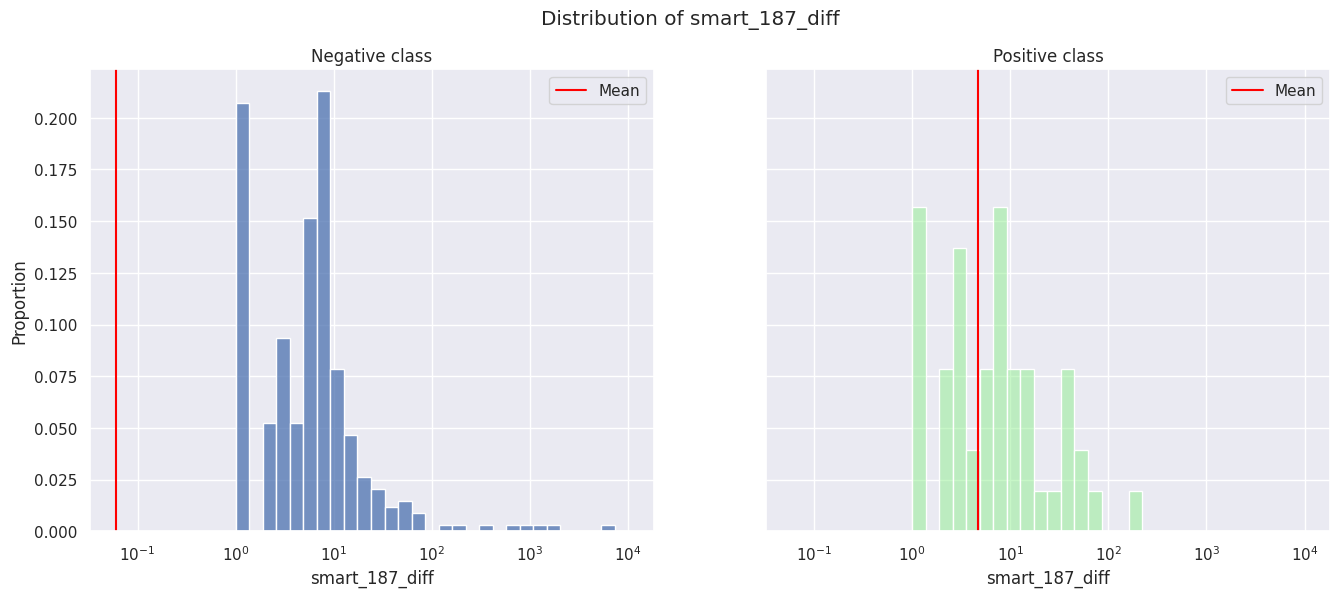

In [21]:
plot_hist(data, col)

После SMOTEENN

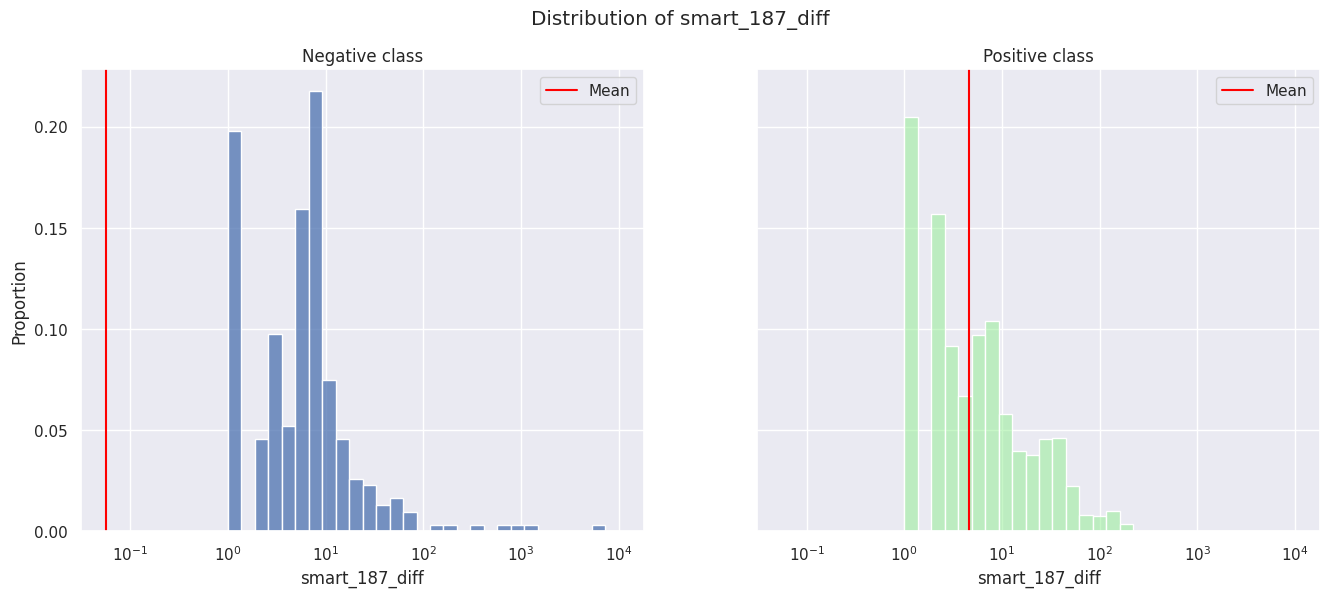

In [22]:
plot_hist(new_data, col)

Характер распределения в обоих классах, в целом, сохранился, как и среднее значение (что важно)

То, что на левом графике красная линия далеко от столбцов, не ошибка - просто большинство значений в классе 0 равно нулю (не отображается на гистограмме, к сожалению)

In [23]:
(
    data
    .groupby("target", as_index=False)
    .agg(
        mean_187_diff=("smart_187_diff", "mean"),
        min_187_diff=("smart_187_diff", "min"),
        max_187_diff=("smart_187_diff", "max"),

    )
)

,target,mean_187_diff,min_187_diff,max_187_diff
0,0,0.059933,0,6337
1,1,4.672619,0,178


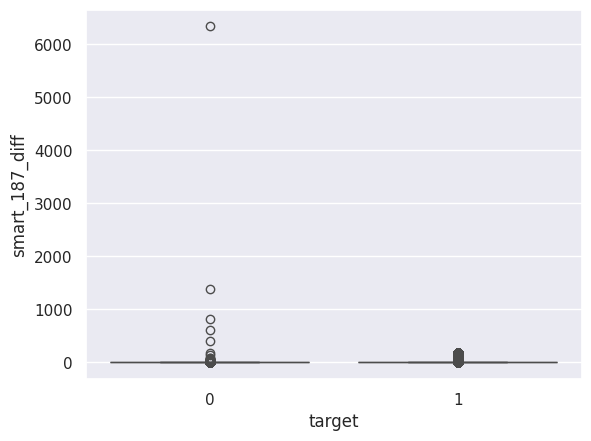

In [24]:
sns.boxplot(data=new_data, y=col, x="target")
plt.show()

Видим, что много выбросов

В дальнейшем можно будет попробовать удалить те сэмплы, которые попадают в 1% наиболее экстремальных сверху и 1% наиболее экстремальных снизу по классу 0, например

Что-то такое
```python
    q_hi  = new_data.query("target == 0")[col].quantile(0.9995)
    q_low = new_data.query("target == 0")[col].quantile(0.0005)
    
    rows_to_drop = (
        new_data
        .query("target == 0")
        [(new_data[col] <= q_low) & (new_data[col] >= q_hi)]
    )
    new_data_filtered = new_data.drop(rows_to_drop.index)
```

In [25]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# new_data["smart_187_diff"] = scaler.fit_transform(np.array(new_data["smart_187_diff"]).reshape(-1, 1))

### smart_199_max

In [26]:
col = "smart_199_max"

В исходных данных

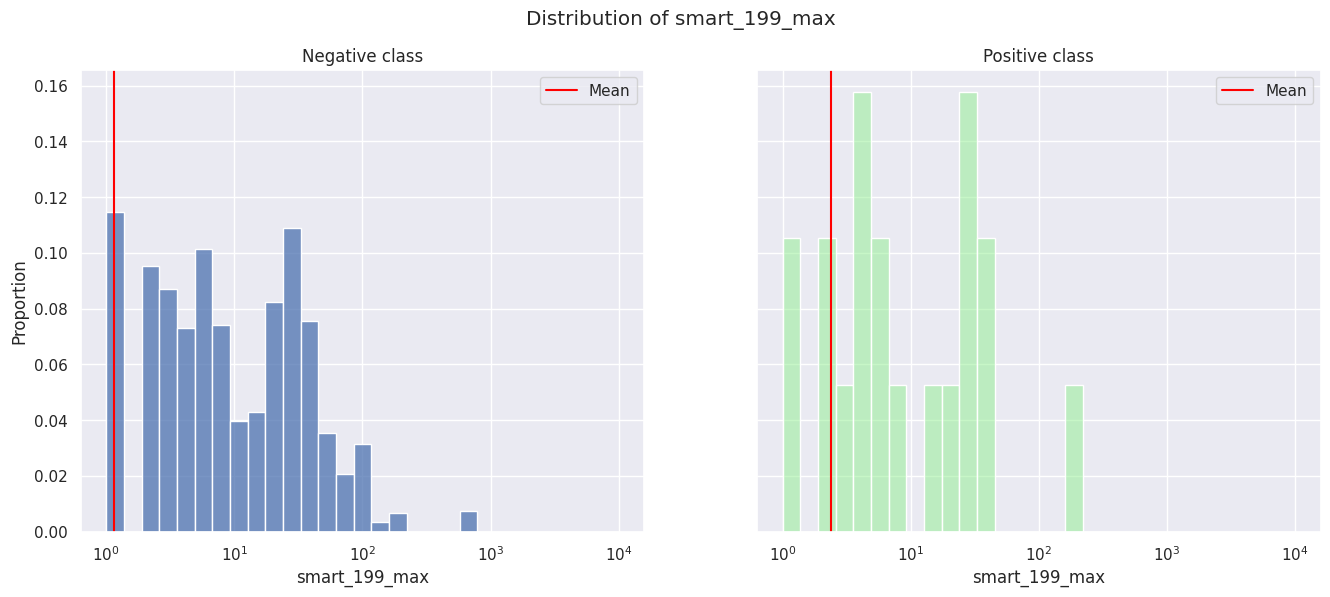

In [27]:
plot_hist(data, col)

После SMOTEENN

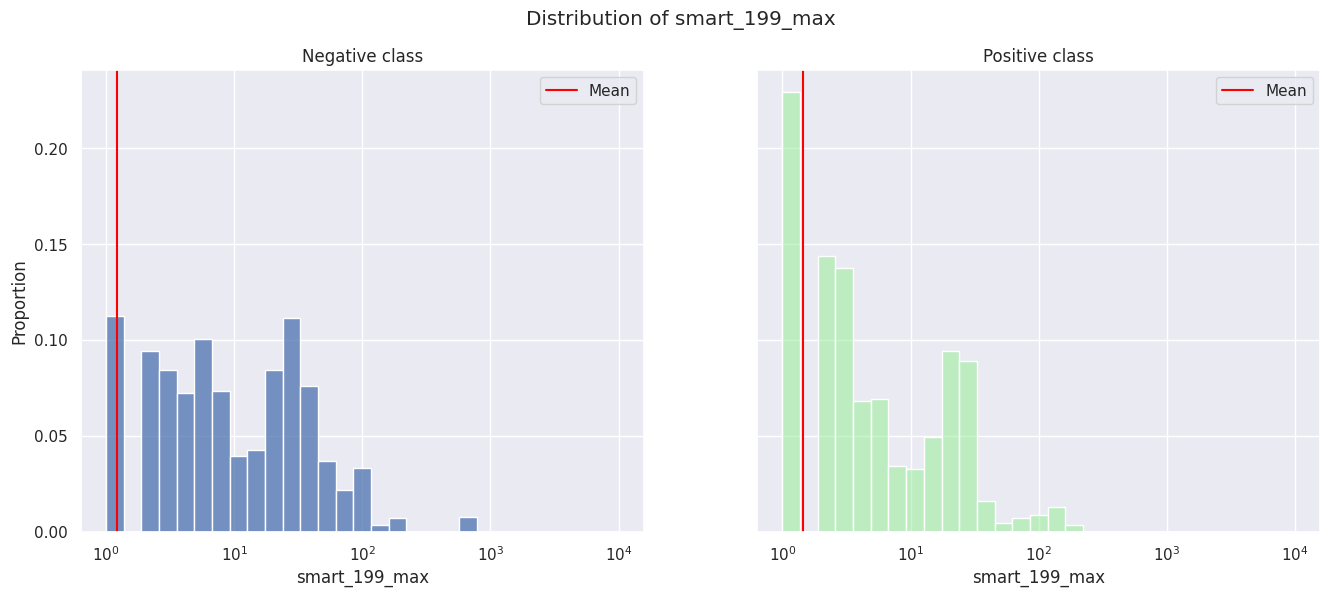

In [28]:
plot_hist(new_data, col)

Среднее в классе 1 сместилось ближе к среднему класса 0, что не очень хорошо

# Preview классификации

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn import tree

Делим на train и test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.25,
    random_state=42
)

Обучаем случайный лес с параметрами по умолчанию (в следующем ноутбуке будет полноценное обучение с подбором параметров)

Пока взяла все признаки

In [31]:
clf = RandomForestClassifier(max_depth=10, random_state=0)

clf.fit(X_train, y_train)

# нужны вероятности классов для AUC-ROC, а не просто метки 
y_pred_proba = clf.predict_proba(X_test)
# метки нужны для других метрик
y_pred = clf.predict(X_test)

Считаем метрики на всем тестовом датасете

In [32]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [33]:
print(f"ROC-AUC: {roc_auc:.4f}\n"
      f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1: {f1:.4f}"
)

ROC-AUC: 0.9908
Precision: 0.9847
Recall: 0.8889
F1: 0.9343


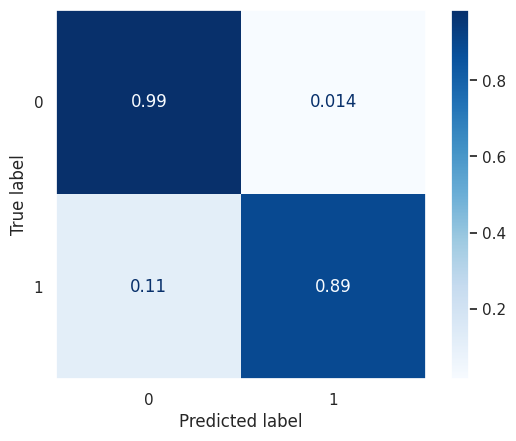

In [34]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize="true"
)
plt.grid(None)
plt.show()

Визуализируем ROC-кривую

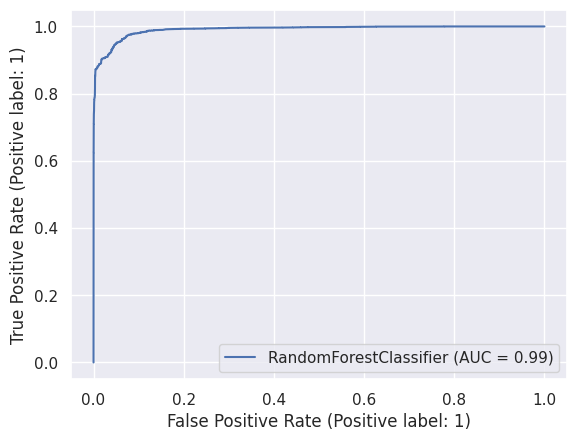

In [35]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.show()

Посчитаем метрики для позитивного класса в реальных данных (до under-/over-sampling), попавших в test

In [36]:
df_test = pd.concat((X_test, y_test), axis=1)
pos_data_in_test = (
    df_test
    .merge(
        data, 
        on=df_test.columns.tolist(), # просто делаем inner join по всем столбцам
        how="inner"
    )
    .query("target == 1") # интересует отдельно позитивный класс
)

In [37]:
real_y_test = pos_data_in_test["target"]
real_y_pred = clf.predict(pos_data_in_test[X_test.columns.tolist()])

In [38]:
# ROC-AUC не считается, если есть только 1 класс
precision = precision_score(real_y_test, real_y_pred)
recall = recall_score(real_y_test, real_y_pred)
f1 = f1_score(real_y_test, real_y_pred)

In [39]:
print(f"Precision (only real positive): {precision:.4f}\n"
      f"Recall (only real positive): {recall:.4f}\n"
      f"F1 (only real positive): {f1:.4f}"
)

Precision (only real positive): 1.0000
Recall (only real positive): 0.7895
F1 (only real positive): 0.8824


Одно из деревьев в ансамбле

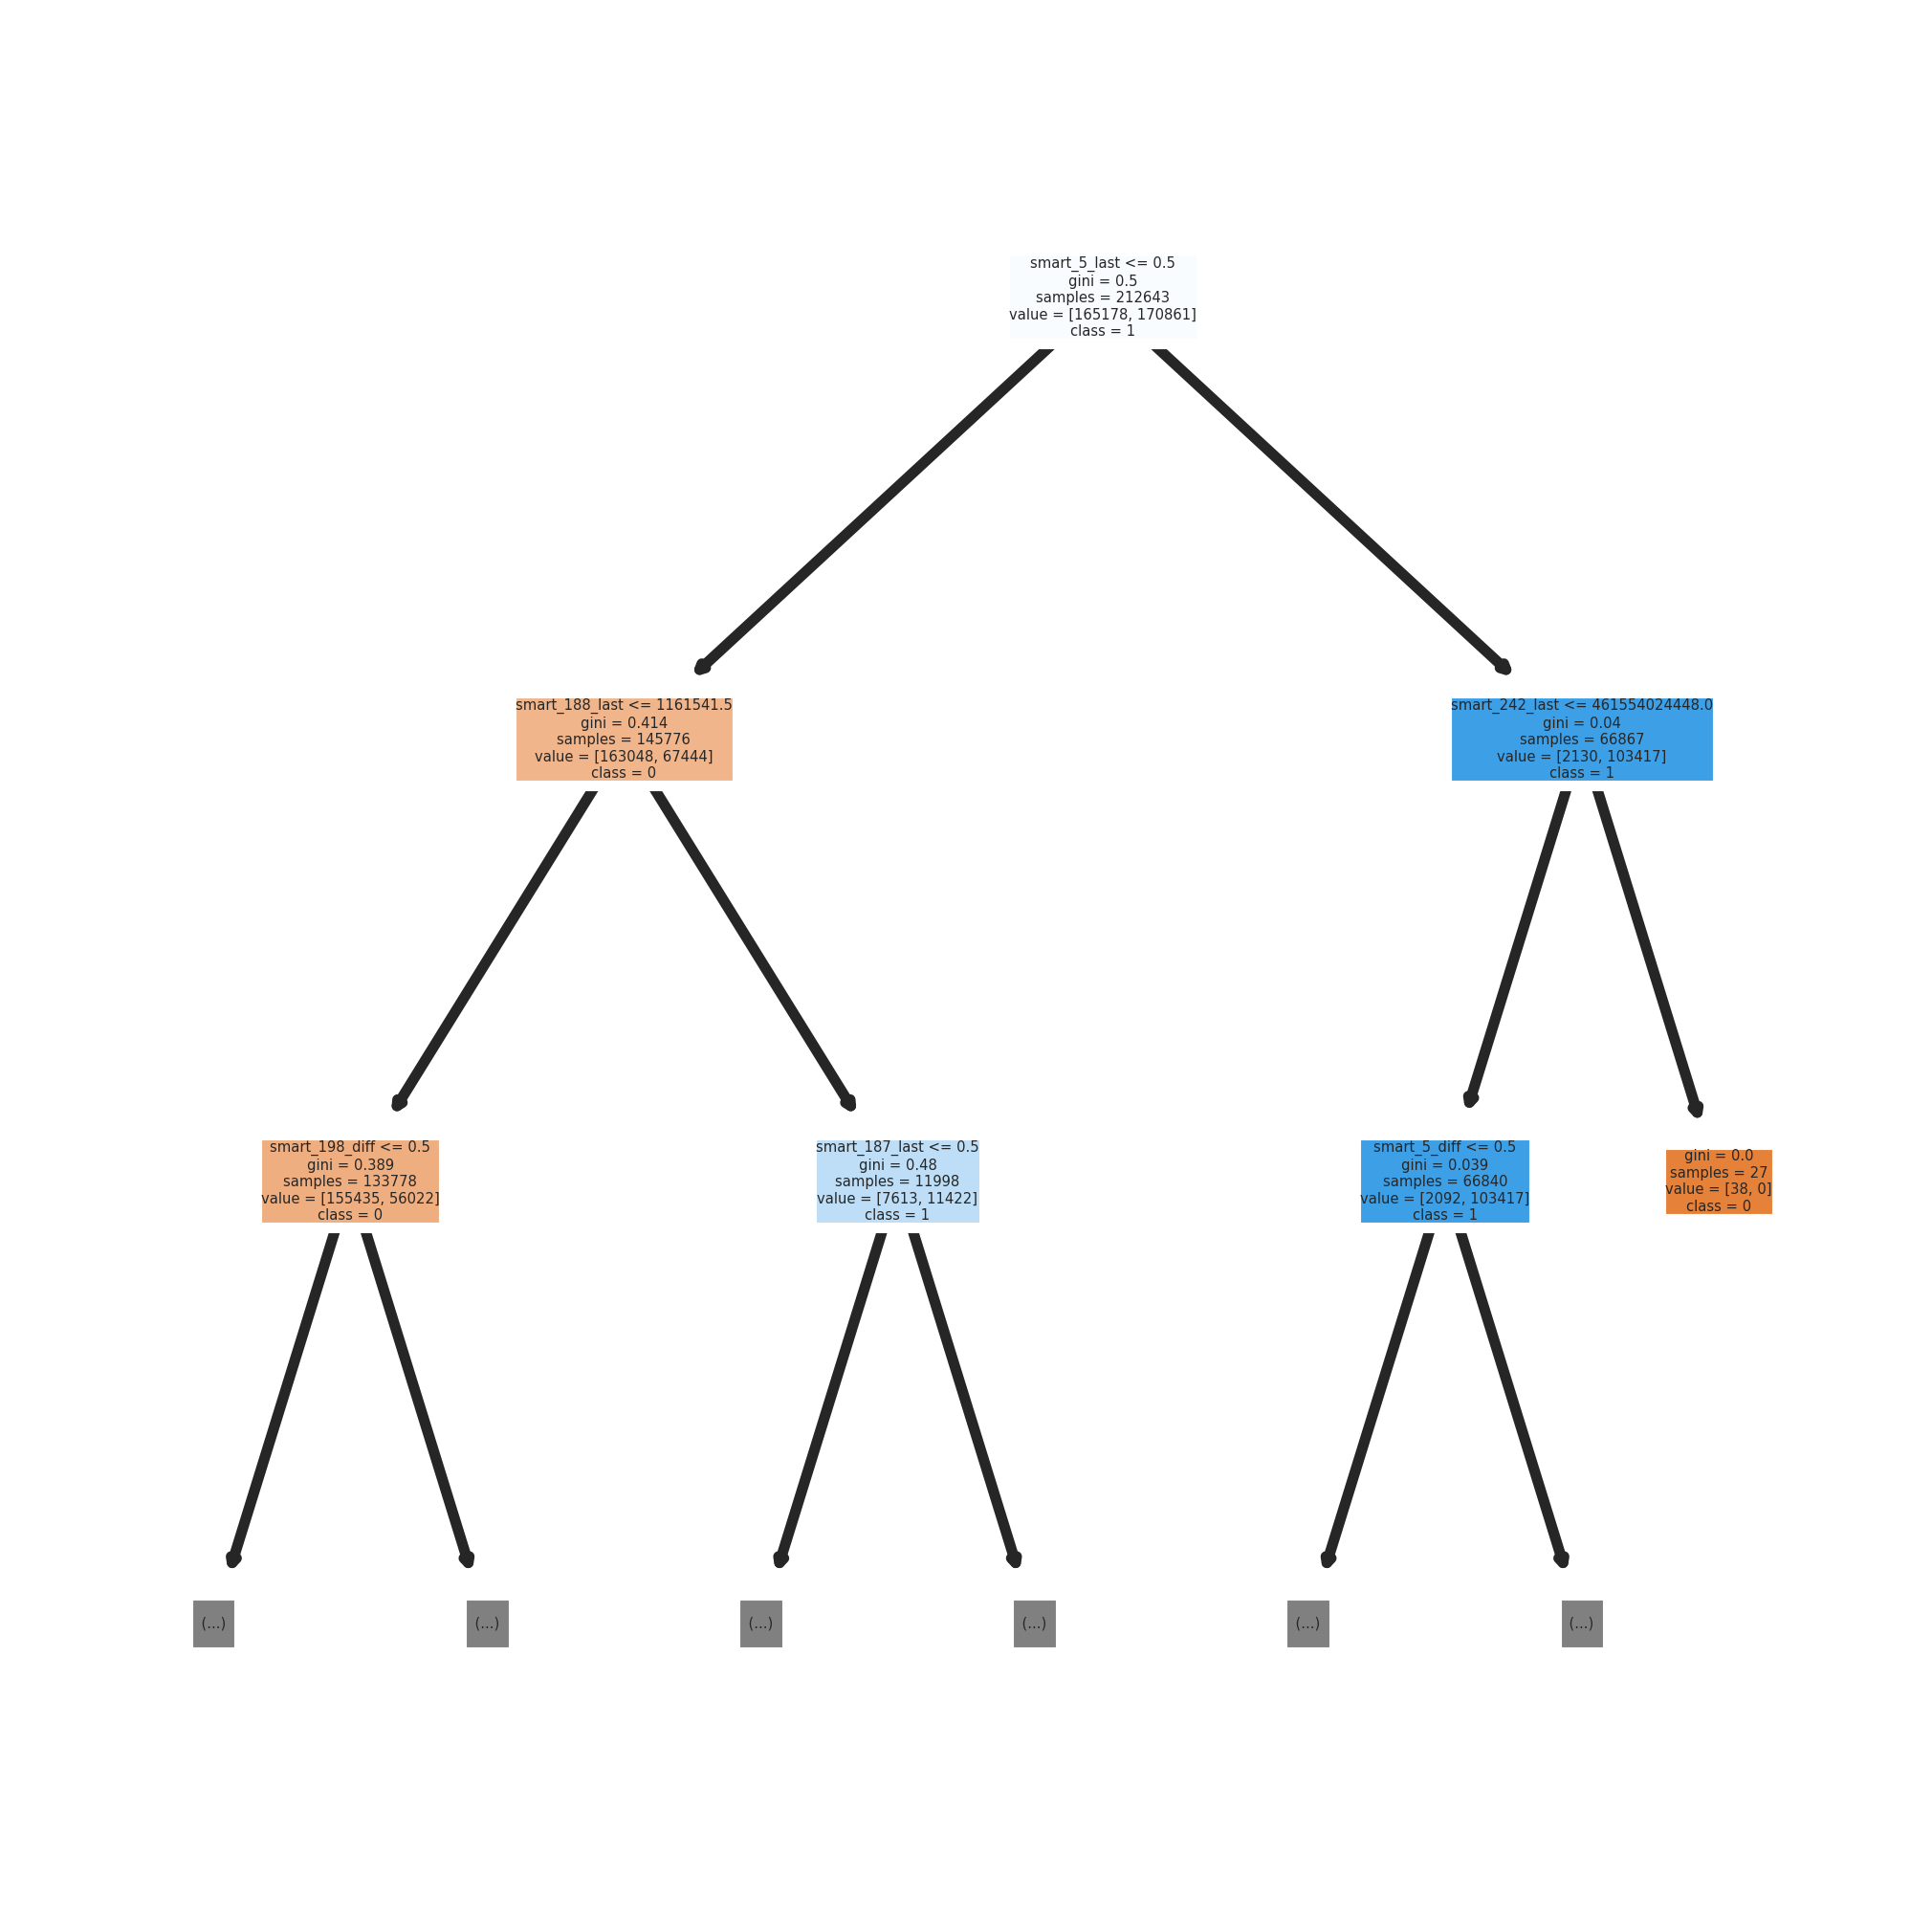

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3), dpi=800)
tree.plot_tree(
    clf.estimators_[63],
    feature_names=X_test.columns.tolist(),
    class_names=["0", "1"],
    max_depth=2,
    filled=True
)
plt.show()